# Moisture transport

Lets get a feel for how moisture moves.
Here I'm looking at the experiment with land NH, but same everything else. 
This is just to get a feel for this field through the following plots

1. Temporal and zonal mean meridional moisture transport
2. Vertical integral of zonally avg'd meridional moisture transport, hovmoller seasonal cycle
3. Seasonal averages (djf, etc..) showing meridional transport as pressure -vs- zonal avg 

In [10]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import glob
import dask.array as da
from copy import deepcopy
import time # to pause while looping through plots

# My functions
sys.path.insert(0,'../tools')
import ds_utils as dsu
import ds_plots as dsp

In [11]:
# Load a single dataset
data_dir = '/workspace/results/acdc/clim'
file_name = data_dir + '/monthlyclimo_northland_same_albedo.nc'
ds, original_time = dsu.load_dataset(file_name)

In [12]:
# Will be using these quite a bit
lat = ds['lat'].values
lon = ds['lon'].values
tmo = np.arange(len(ds['time'].values))
pressure = ds['pfull'].values

## Vertical, zonal, and temporal mean meridional transport 

This is to confirm our plots based on P-E
Assume that `sphum_v` is transport through full pressure layer, so `dp` is the distance in pressure space the transport is going through, which is determined by `phalf`

That is, computing the zonal average of:

$ \bar{\langle qv \rangle}^p = \frac{1}{P_{tot}}\int_{OCE}^{TOA} \langle qv \rangle dp$ 

where $\langle qv \rangle$ is already averaged to monthly climatological values.

First, check out the temporal mean -vs- latitude:

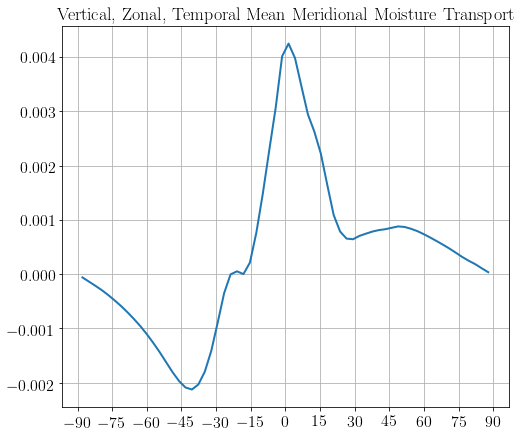

In [13]:
dp = xr.DataArray(np.diff(ds.phalf),dims='pfull')
p_tot = ds.phalf[-1] - ds.phalf[0]

avg_sphum_v = ds.sphum_v * dp
avg_sphum_v = avg_sphum_v.sum('pfull')
avg_sphum_v = np.divide(avg_sphum_v,p_tot)
avg_sphum_v = avg_sphum_v.mean('lon')

plt.figure(figsize=(8,7))
plt.plot(lat,avg_sphum_v.mean('time'))
plt.title('Vertical, Zonal, Temporal Mean Meridional Moisture Transport')
plt.xticks(np.arange(-90,91,15))
plt.grid()


Some comments:
1. We see a transport of moisture from the SH into the NH near the equator, this makes sense in the time mean: net transport of moisture from ocean to land ...
2. We have a positive flux at all NH latitudes, with a second peak near 50N. This means that in the annual mean, we have a transport of moisture to the poles.
3. The SH is a little more complicated at first, because there is more transport around 45S than in the tropics.
4. If the local maxima near $\pm45^\circ$ is associated with the storm track, we see a much stronger storm track in the SH.

Lets look at the seasonal cycle

## Vertical and zonal mean meridional moisture transport, seasonal cycle

(<Figure size 576x504 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b029b4b2400>)

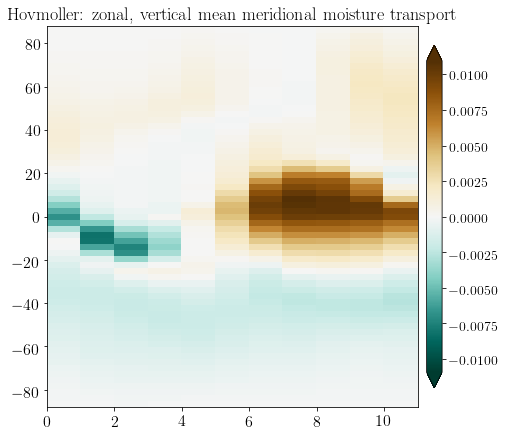

In [14]:
cmax = np.max(np.abs(avg_sphum_v.values))
dsp.hmap(avg_sphum_v,lat,
         cmap='BrBG_r',clim=(-cmax,cmax),
         title='Hovmoller: zonal, vertical mean meridional moisture transport')

1. Max meridional moisture transport moves seasonally with the ITCZ, which makes sense
2. Broader pattern during NH summer. This is seems to show the fact that there is unlimited evaporation over the ocean, being transported and dumped into NH
3. Can see year-round transport of moisture poleward, EXCEPT in NH during August.

## Seasonal moisture flux as a function of pressure (zonal mean)

Now lets look at the pressure layer where moisture is being transported

([], <matplotlib.colorbar.Colorbar at 0x2b0242793748>)

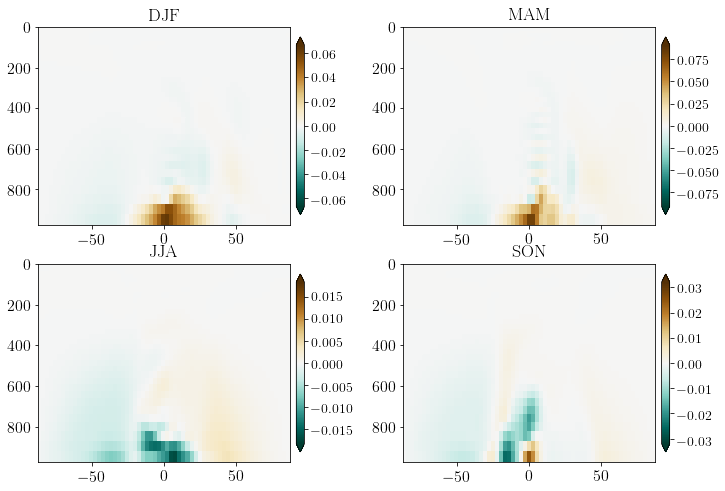

In [15]:
djf = dict(ds.groupby('time.season'))['DJF'].mean('time')
mam = dict(ds.groupby('time.season'))['MAM'].mean('time')
jja = dict(ds.groupby('time.season'))['JJA'].mean('time')
son = dict(ds.groupby('time.season'))['SON'].mean('time')

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
cmax = np.max(np.abs(djf.sphum_v.mean('lon').values))
dsp.pmap(djf.sphum_v.mean('lon'),lat,pressure,
         newfig=False,title='DJF',
         clim=(-cmax,cmax),cmap='BrBG_r')
plt.subplot(2,2,2)
cmax = np.max(np.abs(mam.sphum_v.mean('lon').values))
dsp.pmap(mam.sphum_v.mean('lon'),lat,pressure,
         newfig=False,title='MAM',
         clim=(-cmax,cmax),cmap='BrBG_r')
plt.subplot(2,2,3)
cmax = np.max(np.abs(jja.sphum_v.mean('lon').values))
dsp.pmap(jja.sphum_v.mean('lon'),lat,pressure,
         newfig=False,title='JJA',
         clim=(-cmax,cmax),cmap='BrBG_r')
plt.subplot(2,2,4)
cmax = np.max(np.abs(son.sphum_v.mean('lon').values))
dsp.pmap(son.sphum_v.mean('lon'),lat,pressure,
         newfig=False,title='SON',
         clim=(-cmax,cmax),cmap='BrBG_r')
    

Something seems wrong with the months ... Lets check out surface temperature just to make sure things are right

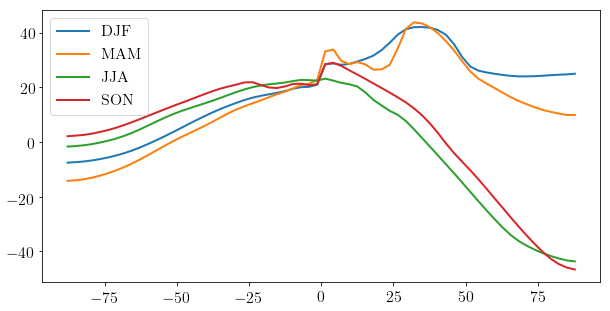

In [16]:
plt.figure(figsize=(10,5))
plt.plot(lat,djf.t_surf.mean('lon'),
         lat,mam.t_surf.mean('lon'),
         lat,jja.t_surf.mean('lon'),
         lat,son.t_surf.mean('lon'))
plt.legend(('DJF','MAM','JJA','SON'))
plt.show()

#### Ok something is wrong with how xarray is grabbing seasons, because DJF shouldn't have a hot NH...

#### Looking below, it looks like the time is labeled as July->Dec, Jan->June 

In [17]:
print(ds.time.dt.month)
print(ds.time.dt.season)

<xarray.DataArray 'month' (time: 12)>
array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])
Coordinates:
  * time     (time) object 0020-07-16 00:00:00 ... 0021-06-16 00:00:00
<xarray.DataArray 'season' (time: 12)>
array(['JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA'], dtype='<U3')
Coordinates:
  * time     (time) object 0020-07-16 00:00:00 ... 0021-06-16 00:00:00


In [18]:
print(original_time)

[7035. 7065. 7095. 7125. 7155. 7185. 7215. 7245. 7275. 7305. 7335. 7365.]


#### Ok so this shows the original time vector, which is 'days since Jan 1, year 1'. Is this correct? Is this just printed incorrectly?